In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(np.float32)

In [4]:
inputs = Input(shape=(28,28,1))
x = Conv2D(4, 3, bias_initializer='random_normal')(inputs)
model = Model(inputs, x)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 4)         40        
                                                                 
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


In [6]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8
converter._experimental_disable_per_channel = True
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmp8klfmx4q/assets


INFO:tensorflow:Assets written to: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmp8klfmx4q/assets
/Users/sty/miniforge3/envs/tf-cpu/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-08 22:25:49.419293: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-08 22:25:49.419305: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-08 22:25:49.419425: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmp8klfmx4q
2022-12-08 22:25:49.419740: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-08 22:25:49.419745: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info 

In [8]:
'''
Create interpreter, allocate tensors
'''
tflite_interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
tflite_interpreter.allocate_tensors()

'''
Check input/output details
'''
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

'''
This gives a list of dictionaries. 
'''
tensor_details = tflite_interpreter.get_tensor_details()

for dict in tensor_details:
    i = dict['index']
    tensor_name = dict['name']
    scales = dict['quantization'][0]
    zero_points = dict['quantization'][1]
    tensor = tflite_interpreter.tensor(i)()

    #print(i, type, tensor_name, scales.shape, zero_points.shape, tensor.shape)
    print(dict)
    if "Conv2D" in tensor_name:
        weights = tensor
        scale = scales
        print(tensor)
    if "Bias" in tensor_name:
        biases = tensor
        print(tensor)

== Input details ==
name: serving_default_input_1:0
shape: [ 1 28 28  1]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 26 26  4]
type: <class 'numpy.float32'>
{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'model/conv2d/BiasAdd/ReadVariableOp', 'index': 1, 'shape': array([4], dtype=int32), 'shape_signature': array([4], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0028500461485236883, 0), 'quantization_parameters': {'scales': array([0.00285005], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
[ 18 -31   3  25]
{'name': 'model/conv2

INFO: Initialized TensorFlow Lite runtime.
INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


In [9]:
weights = np.rollaxis(weights, 0,4)

In [10]:
A = weights*scale
A

array([[[[ 0.32205521, -0.0370506 ,  0.00855014, -0.03135051]],

        [[ 0.28500461, -0.16815272, -0.19950323,  0.03990065]],

        [[ 0.29925485, -0.20235328,  0.34770563,  0.33915549]]],


       [[[ 0.28500461, -0.12825208, -0.11400185, -0.27930452]],

        [[ 0.23085374,  0.23085374, -0.36195586, -0.16530268]],

        [[-0.13680222, -0.17100277,  0.30210489, -0.1111518 ]]],


       [[[-0.12825208,  0.15675254,  0.10830175, -0.05415088]],

        [[-0.21660351,  0.30495494, -0.27645448, -0.01425023]],

        [[-0.05700092,  0.07125115, -0.17955291,  0.01710028]]]])

In [11]:
B = model.weights[0].numpy()
B

array([[[[ 0.32304007, -0.03825197,  0.00947043, -0.03106147]],

        [[ 0.28605455, -0.16937381, -0.19900963,  0.03882751]],

        [[ 0.30011785, -0.20131066,  0.3478405 ,  0.33982933]]],


       [[[ 0.28405195, -0.12947306, -0.11278489, -0.27868629]],

        [[ 0.23135966,  0.23095816, -0.36195585, -0.1662883 ]],

        [[-0.13780653, -0.17211406,  0.30166155, -0.11059293]]],


       [[[-0.12738235,  0.15754533,  0.10828841, -0.05358925]],

        [[-0.21629494,  0.30389327, -0.2764272 , -0.01396909]],

        [[-0.05680344,  0.07147413, -0.18066274,  0.01620162]]]],
      dtype=float32)

In [12]:
((A-B)**2).mean()**.5

0.0007996446248029882

In [13]:
A = biases*scale

In [14]:
B = model.weights[1].numpy()

In [15]:
((A-B)**2).mean()**.5

0.0009069952896508898

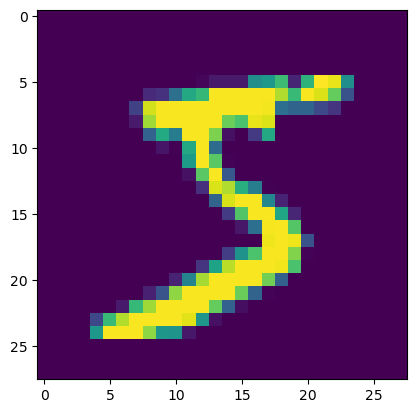

In [16]:
X = X_train[[0]]
plt.imshow(X[0])

In [17]:
y = model.predict(X)

1/1 [==============================] - 0s 34ms/step


-109.355644 332.39246 36.14158


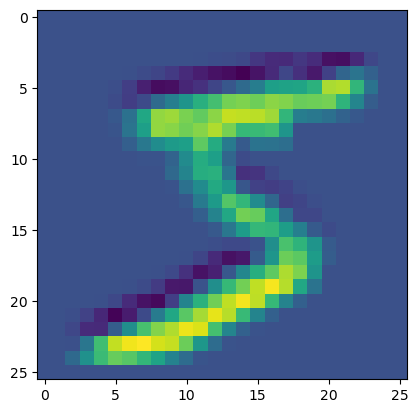

In [18]:
A = y[0,:,:,0]
print(A.min(), A.max(), A.mean())
plt.imshow(A)

-101.61839 330.2263 36.025753


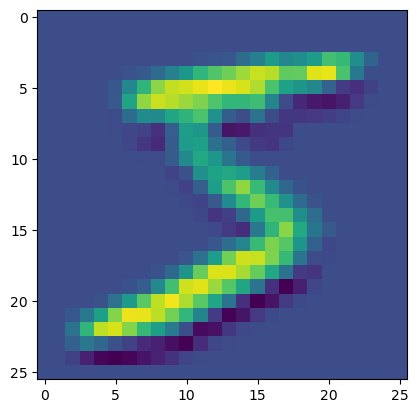

In [19]:
B = (convolve2d(X[0,:,:,0], weights[:,:,0,0], mode="valid")+biases[0])*scale
print(B.min(), B.max(), B.mean())
plt.imshow(B)

In [20]:
((A-B)**2).mean()**.5

124.22025549402159

In [21]:
in_json = {
    "in": X.astype(int).flatten().tolist(),
    "weights": weights.flatten().tolist(),
    "bias": biases.flatten().tolist(),
}

In [22]:
out_json = {
    "scale": scale,
    "out": y.flatten().tolist(),
}

In [23]:
import json

In [24]:
with open("conv2D_input.json", "w") as f:
    json.dump(in_json, f)

In [25]:
with open("conv2D_output.json", "w") as f:
    json.dump(out_json, f)

In [26]:
inputs = Input(shape=(28,28,1))
x = Conv2D(4, 3, 2, bias_initializer='random_normal')(inputs)
model = Model(inputs, x)

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 4)         40        
                                                                 
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8
converter._experimental_disable_per_channel = True
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmpe6yqlypi/assets


INFO:tensorflow:Assets written to: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmpe6yqlypi/assets
/Users/sty/miniforge3/envs/tf-cpu/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-08 22:25:50.563360: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-08 22:25:50.563371: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-08 22:25:50.563455: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmpe6yqlypi
2022-12-08 22:25:50.563780: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-08 22:25:50.563785: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info 

In [29]:
'''
Create interpreter, allocate tensors
'''
tflite_interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
tflite_interpreter.allocate_tensors()

'''
Check input/output details
'''
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

'''
This gives a list of dictionaries. 
'''
tensor_details = tflite_interpreter.get_tensor_details()

for dict in tensor_details:
    i = dict['index']
    tensor_name = dict['name']
    scales = dict['quantization'][0]
    zero_points = dict['quantization'][1]
    tensor = tflite_interpreter.tensor(i)()

    #print(i, type, tensor_name, scales.shape, zero_points.shape, tensor.shape)
    print(dict)
    if "Conv2D" in tensor_name:
        weights = tensor
        scale = scales
        print(tensor)
    if "Bias" in tensor_name:
        biases = tensor
        print(tensor)

== Input details ==
name: serving_default_input_2:0
shape: [ 1 28 28  1]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 13 13  4]
type: <class 'numpy.float32'>
{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'model_1/conv2d_1/BiasAdd/ReadVariableOp', 'index': 1, 'shape': array([4], dtype=int32), 'shape_signature': array([4], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0028172738384455442, 0), 'quantization_parameters': {'scales': array([0.00281727], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
[-25  14   7 -22]
{'name': 'model_1

INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


In [30]:
'''
Create interpreter, allocate tensors
'''
tflite_interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
tflite_interpreter.allocate_tensors()

'''
Check input/output details
'''
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

'''
This gives a list of dictionaries. 
'''
tensor_details = tflite_interpreter.get_tensor_details()

for dict in tensor_details:
    i = dict['index']
    tensor_name = dict['name']
    scales = dict['quantization'][0]
    zero_points = dict['quantization'][1]
    tensor = tflite_interpreter.tensor(i)()

    #print(i, type, tensor_name, scales.shape, zero_points.shape, tensor.shape)
    print(dict)
    if "Conv2D" in tensor_name:
        weights = tensor
        scale = scales
        print(tensor)
    if "Bias" in tensor_name:
        biases = tensor
        print(tensor)

== Input details ==
name: serving_default_input_2:0
shape: [ 1 28 28  1]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 13 13  4]
type: <class 'numpy.float32'>
{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'model_1/conv2d_1/BiasAdd/ReadVariableOp', 'index': 1, 'shape': array([4], dtype=int32), 'shape_signature': array([4], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0028172738384455442, 0), 'quantization_parameters': {'scales': array([0.00281727], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
[-25  14   7 -22]
{'name': 'model_1

INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


In [31]:
weights = np.rollaxis(weights, 0,4)

In [32]:
weights*scale

array([[[[-0.23946828, -0.35779378,  0.1183255 , -0.34934196]],

        [[-0.26200647, -0.32398649,  0.34089013,  0.14931551]],

        [[-0.06198002, -0.09578731, -0.16903643,  0.15495006]]],


       [[[-0.08451822,  0.33243831,  0.14649824, -0.01690364]],

        [[ 0.03380729,  0.28454466,  0.00845182, -0.08733549]],

        [[-0.18594007,  0.17467098, -0.25073737, -0.32962104]]],


       [[[-0.03662456,  0.34089013, -0.20847826, -0.13241187]],

        [[ 0.24510282,  0.03944183, -0.07324912,  0.10142186]],

        [[ 0.25918919,  0.20284372, -0.28454466,  0.07043185]]]])

In [33]:
model.weights[0].numpy()

array([[[[-0.24029627, -0.35779378,  0.11926487, -0.34880555]],

        [[-0.26081884, -0.32343784,  0.33997107,  0.1484912 ]],

        [[-0.0624994 , -0.09563485, -0.16974111,  0.15483648]]],


       [[[-0.08496213,  0.3321957 ,  0.14558834, -0.01620248]],

        [[ 0.03391108,  0.2846266 ,  0.00959182, -0.08620036]],

        [[-0.18486303,  0.17396384, -0.25193584, -0.3290667 ]]],


       [[[-0.03583366,  0.34142935, -0.20717299, -0.1330333 ]],

        [[ 0.24595392,  0.04008681, -0.07273945,  0.10033521]],

        [[ 0.25793636,  0.20322996, -0.28320706,  0.06933329]]]],
      dtype=float32)

In [34]:
biases*scale

array([-0.07043185,  0.03944183,  0.01972092, -0.06198002])

In [35]:
model.weights[1].numpy()

array([-0.07078537,  0.03924986,  0.0202689 , -0.06291825], dtype=float32)

In [36]:
X = X_train[[0]]
X.shape

(1, 28, 28, 1)

In [37]:
y = model.predict(X)
y

1/1 [==============================] - 0s 21ms/step


array([[[[-7.07853660e-02,  3.92498598e-02,  2.02689040e-02,
          -6.29182458e-02],
         [-7.07853660e-02,  3.92498598e-02,  2.02689040e-02,
          -6.29182458e-02],
         [-7.07853660e-02,  3.92498598e-02,  2.02689040e-02,
          -6.29182458e-02],
         [-7.07853660e-02,  3.92498598e-02,  2.02689040e-02,
          -6.29182458e-02],
         [-7.07853660e-02,  3.92498598e-02,  2.02689040e-02,
          -6.29182458e-02],
         [-7.07853660e-02,  3.92498598e-02,  2.02689040e-02,
          -6.29182458e-02],
         [-7.07853660e-02,  3.92498598e-02,  2.02689040e-02,
          -6.29182458e-02],
         [-7.07853660e-02,  3.92498598e-02,  2.02689040e-02,
          -6.29182458e-02],
         [-7.07853660e-02,  3.92498598e-02,  2.02689040e-02,
          -6.29182458e-02],
         [-7.07853660e-02,  3.92498598e-02,  2.02689040e-02,
          -6.29182458e-02],
         [-7.07853660e-02,  3.92498598e-02,  2.02689040e-02,
          -6.29182458e-02],
         [-7.07853660

In [38]:
in_json = {
    "in": X.astype(int).flatten().tolist(),
    "weights": weights.flatten().tolist(),
    "bias": biases.flatten().tolist(),
}

In [39]:
out_json = {
    "scale": scale,
    "out": y.flatten().tolist()
}

In [40]:
with open("conv2D_stride_input.json", "w") as f:
    json.dump(in_json, f)

In [41]:
with open("conv2D_stride_output.json", "w") as f:
    json.dump(out_json, f)